In [ ]:
! pip install --upgrade scikit-learn

In [ ]:
! pip install scikit-learn-extra

In [ ]:
! pip install hdbscan

In [ ]:
! python -m spacy download en_core_web_sm

---

# Book Crossing - Classification (Unsupervised)

In [3]:
%matplotlib inline

import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set()
palette = sns.color_palette("icefire")

plt.style.use('ggplot')

sns.set_context("talk")

In [127]:
dataset = pd.read_csv('book_crossing.classification.cleaned.csv')

In [128]:
dataset['age'] = dataset['age'].astype(np.float64)
dataset['book_rating'] = dataset['book_rating'].astype('category')
dataset['book_title'] = dataset['book_title'].astype('category')
dataset['book_author'] = dataset['book_author'].astype('category')
dataset['year_of_publication'] = dataset['year_of_publication'].astype(np.float64)
dataset['publisher'] = dataset['publisher'].astype('category')
dataset['country'] = dataset['country'].astype('category')

In [136]:
dataset['book_title'].cat.categories.shape

(132033,)

In [139]:
dataset['book_author'].cat.categories.shape

(60652,)

In [140]:
dataset['publisher'].cat.categories.shape

(11311,)

In [141]:
dataset['country'].cat.categories.shape

(51,)

In [6]:
dataset.head()

,age,book_rating,book_title,book_author,year_of_publication,publisher,country
0,34.0,mid,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada
1,30.0,high,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada
2,34.0,high,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada
3,34.0,high,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada
4,34.0,high,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,canada


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364570 entries, 0 to 364569
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   age                  364570 non-null  float64 
 1   book_rating          364570 non-null  category
 2   book_title           364570 non-null  category
 3   book_author          364570 non-null  category
 4   year_of_publication  364570 non-null  float64 
 5   publisher            364570 non-null  category
 6   country              364570 non-null  category
dtypes: category(5), float64(2)
memory usage: 19.1 MB


In [8]:
c_dataset = dataset["book_title"].astype(str) + " "  + \
            dataset["book_author"].astype(str) + " " + \
            dataset["publisher"].astype(str) + " " + \
            dataset["year_of_publication"].astype(str) + " " + \
            dataset["age"].astype(str) + " " + \
            dataset["country"].astype(str)


In [9]:
for ex in c_dataset.sample(frac=0.2)[:5]:
    print(ex)

The Vanishing Vampire (The Accidental Monsters , No 1) David Lubar Scholastic 1997.0 12.0 usa
REMEMBER ME Mary Higgins Clark Simon &amp; Schuster 1994.0 34.0 usa
The Mummy or Ramses the Damned Anne Rice Ballantine Books 1991.0 22.0 usa
Bittersweet Rain Sandra Brown Warner Books 2000.0 34.0 usa
Arthur Stephen R. Lawhead Zondervan Publishing Company 1996.0 21.0 usa


In [92]:
small_dataset = dataset.copy().sample(frac=0.03)

In [93]:
small_dataset.shape

(10937, 7)

In [94]:
c_dataset_small = small_dataset["book_title"].astype(str) + " "  + \
                  small_dataset["book_author"].astype(str) + " " + \
                  small_dataset["publisher"].astype(str) + " " + \
                  small_dataset["year_of_publication"].astype(str) + " " + \
                  small_dataset["age"].astype(str) + " " + \
                  small_dataset["country"].astype(str)

In [95]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
import en_core_web_sm

nlp = en_core_web_sm.load()

In [96]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.cluster import KMeans, DBSCAN, Birch, MiniBatchKMeans, SpectralClustering, AgglomerativeClustering, MeanShift, AffinityPropagation, OPTICS
from sklearn.decomposition import TruncatedSVD

set_config(display='diagram')

In [97]:
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        return [self.nlp(text).vector for text in X]

In [98]:
X, y = c_dataset, dataset['book_rating']

In [99]:
X_small, y_small = c_dataset_small, small_dataset['book_rating']

In [100]:
target_names = ['low', 'mid', 'high']

## Unsupervised Models

- KMedoids
- AgglomerativeClustering
- DBSCAN
- KMeansClustering
- HDBSCAN
- MiniBatchKMeans

In [102]:
"""
km = KMeans(n_clusters=3) # works (needs remap of output)
dbscan = DBSCAN()
birch = Birch() # crash
mbkm = MiniBatchKMeans() # works (needs remap of output)
sc = SpectralClustering() # crash
ac = AgglomerativeClustering() # sparse not supported
ms = MeanShift(bandwidth=3) # sparse not supported
ap = AffinityPropagation() # crash
oo = OPTICS() # sparse not supported
"""

'\nkm = KMeans(n_clusters=3) # works (needs remap of output)\ndbscan = DBSCAN()\nbirch = Birch() # crash\nmbkm = MiniBatchKMeans() # works (needs remap of output)\nsc = SpectralClustering() # crash\nac = AgglomerativeClustering() # sparse not supported\nms = MeanShift(bandwidth=3) # sparse not supported\nap = AffinityPropagation() # crash\noo = OPTICS() # sparse not supported\n'

In [103]:
from time import time

def fit_model(algorithm, data):

    t1 = time()

    X, y = data
    
    print(f'\nStarted Training {algorithm.__class__.__name__} on X: {X.shape} y: {y.shape}')

    embeddings_pipeline = Pipeline(
        steps=[
            ("mean_embeddings", SpacyVectorTransformer(nlp=nlp)),
            ("reduce_dim", TruncatedSVD(50)),
            ("clusterer", algorithm),
        ]
    )

    # train the model
    embeddings_pipeline.fit(X, y)

    print(f"\nEvaluating model on X_test: {X.shape} y_test: {y.shape}")

    # test the model
    y_true = y.copy()

    if isinstance(embeddings_pipeline['clusterer'], (AgglomerativeClustering, DBSCAN, OPTICS, HDBSCAN)):
        y_pred = embeddings_pipeline['clusterer'].labels_
    else:
        y_pred = embeddings_pipeline.predict(X)
    
    y_pred = np.array(list(map(lambda x: "low" if x == 0 else "mid" if x == 1 else "high", y_pred)))

    # get the classification report
    print(f"\nClassification Report for {algorithm.__class__.__name__}")
    print(classification_report(y_true, y_pred, target_names=target_names, labels=target_names))

    acc_score = accuracy_score(y_true, y_pred)
    bal_score = balanced_accuracy_score(y_true, y_pred)
    
    print(f"\nAccuracy Score: {acc_score}")
    print(f"Balanced Accuracy Score: {bal_score}")

    print()
    # show the confusion matrix
    cmmat_table = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    conmat = pd.crosstab(cmmat_table.y_true, cmmat_table.y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True, normalize='all')
    ax = plt.axes()
    sns.set(rc={'figure.figsize':(9, 7)})
    sns.heatmap(conmat, annot=True, ax=ax)
    ax.set_title(f'{algorithm.__class__.__name__}')
    plt.show()
    print()

    t2 = time()

    print(f'Trained {algorithm.__class__.__name__} in {(t2 - t1)}s')

    return embeddings_pipeline
    

## KMedoids Clustering

In [107]:
from sklearn_extra.cluster import KMedoids

In [108]:
kmedoids = KMedoids(n_clusters=3, max_iter=1)


Started Training KMedoids on X: (10937,) y: (10937,)

Evaluating model on X_test: (10937,) y_test: (10937,)

Classification Report for KMedoids
              precision    recall  f1-score   support

         low       0.02      0.34      0.04       231
         mid       0.38      0.30      0.34      4333
        high       0.60      0.31      0.41      6373

    accuracy                           0.31     10937
   macro avg       0.33      0.32      0.26     10937
weighted avg       0.50      0.31      0.37     10937


Accuracy Score: 0.30785407332906645
Balanced Accuracy Score: 0.3184037656596693



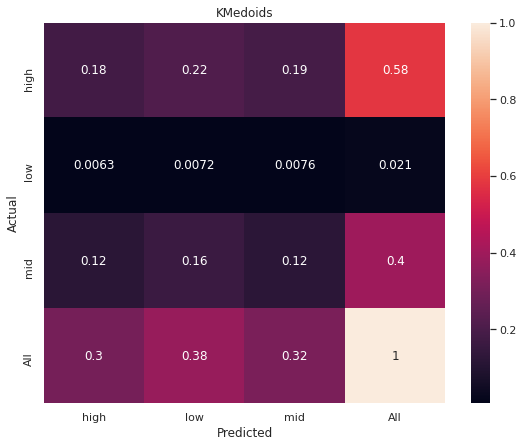


Trained KMedoids in 223.7921495437622s


In [109]:
clf = fit_model(algorithm=kmedoids, data=(X_small, y_small))

In [110]:
clf

Pipeline(steps=[('mean_embeddings',
                 SpacyVectorTransformer(nlp=<spacy.lang.en.English object at 0x7ff253d3b6d8>)),
                ('reduce_dim', TruncatedSVD(n_components=50)),
                ('clusterer', KMedoids(max_iter=1, n_clusters=3))])

## Agglomerative Clustering

In [111]:
aggc = AgglomerativeClustering(n_clusters=3)


Started Training AgglomerativeClustering on X: (10937,) y: (10937,)

Evaluating model on X_test: (10937,) y_test: (10937,)

Classification Report for AgglomerativeClustering
              precision    recall  f1-score   support

         low       0.02      0.37      0.04       231
         mid       0.37      0.31      0.34      4333
        high       0.57      0.24      0.34      6373

    accuracy                           0.27     10937
   macro avg       0.32      0.31      0.24     10937
weighted avg       0.48      0.27      0.33     10937


Accuracy Score: 0.2729267623662796
Balanced Accuracy Score: 0.30877414843520845



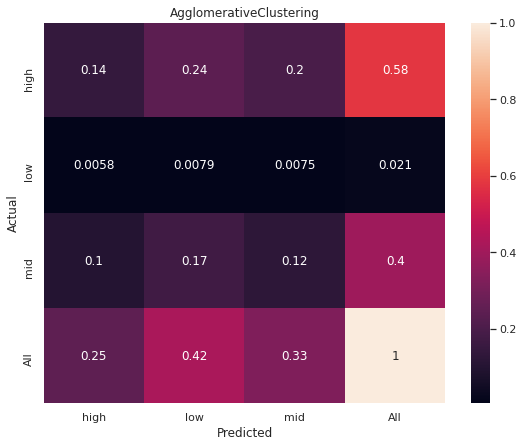


Trained AgglomerativeClustering in 119.64335346221924s


In [112]:
clf = fit_model(algorithm=aggc, data=(X_small, y_small))

In [113]:
clf

Pipeline(steps=[('mean_embeddings',
                 SpacyVectorTransformer(nlp=<spacy.lang.en.English object at 0x7ff253d3b6d8>)),
                ('reduce_dim', TruncatedSVD(n_components=50)),
                ('clusterer', AgglomerativeClustering(n_clusters=3))])

## DBSCAN

In [114]:
dbscan = DBSCAN(n_jobs=-1)


Started Training DBSCAN on X: (10937,) y: (10937,)

Evaluating model on X_test: (10937,) y_test: (10937,)

Classification Report for DBSCAN
              precision    recall  f1-score   support

         low       0.00      0.00      0.00       231
         mid       0.20      0.00      0.00      4333
        high       0.58      1.00      0.74      6373

    accuracy                           0.58     10937
   macro avg       0.26      0.33      0.25     10937
weighted avg       0.42      0.58      0.43     10937


Accuracy Score: 0.5818780287098839
Balanced Accuracy Score: 0.3328872224199264



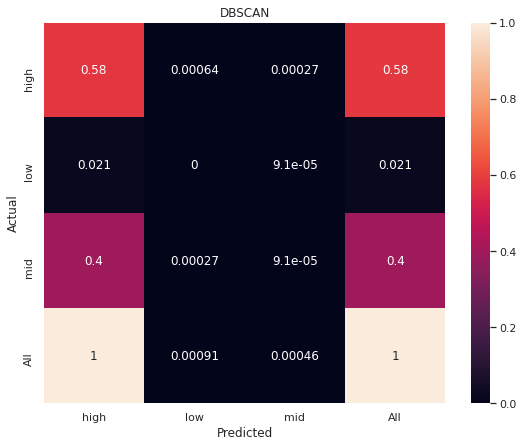


Trained DBSCAN in 116.67007970809937s


In [115]:
clf = fit_model(algorithm=dbscan, data=(X_small, y_small))

In [116]:
clf

Pipeline(steps=[('mean_embeddings',
                 SpacyVectorTransformer(nlp=<spacy.lang.en.English object at 0x7ff253d3b6d8>)),
                ('reduce_dim', TruncatedSVD(n_components=50)),
                ('clusterer', DBSCAN(n_jobs=-1))])

## KMeans Clustering

In [117]:
kmeans = KMeans(n_clusters=3, n_init=3)


Started Training KMeans on X: (10937,) y: (10937,)

Evaluating model on X_test: (10937,) y_test: (10937,)

Classification Report for KMeans
              precision    recall  f1-score   support

         low       0.02      0.40      0.04       231
         mid       0.39      0.26      0.32      4333
        high       0.60      0.35      0.44      6373

    accuracy                           0.32     10937
   macro avg       0.34      0.34      0.27     10937
weighted avg       0.50      0.32      0.38     10937


Accuracy Score: 0.31535155892840816
Balanced Accuracy Score: 0.33658550914710594



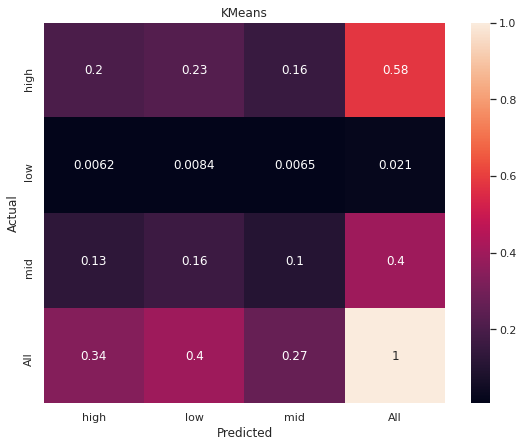


Trained KMeans in 222.76584196090698s


In [118]:
clf = fit_model(algorithm=kmeans, data=(X_small, y_small))

In [119]:
clf

Pipeline(steps=[('mean_embeddings',
                 SpacyVectorTransformer(nlp=<spacy.lang.en.English object at 0x7ff253d3b6d8>)),
                ('reduce_dim', TruncatedSVD(n_components=50)),
                ('clusterer', KMeans(n_clusters=3, n_init=3))])

## HDBSCAN

In [120]:
from hdbscan import HDBSCAN

In [121]:
hscan = HDBSCAN(min_cluster_size=3)


Started Training HDBSCAN on X: (10937,) y: (10937,)

Evaluating model on X_test: (10937,) y_test: (10937,)

Classification Report for HDBSCAN
              precision    recall  f1-score   support

         low       0.00      0.00      0.00       231
         mid       0.50      0.00      0.00      4333
        high       0.58      1.00      0.74      6373

    accuracy                           0.58     10937
   macro avg       0.36      0.33      0.25     10937
weighted avg       0.54      0.58      0.43     10937


Accuracy Score: 0.5824266252171528
Balanced Accuracy Score: 0.3332256713684369



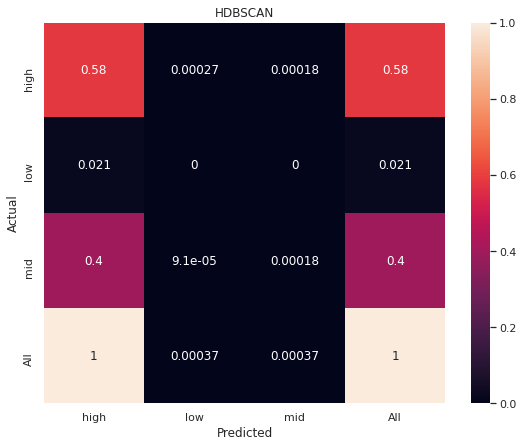


Trained HDBSCAN in 121.39391756057739s


In [122]:
clf = fit_model(algorithm=hscan, data=(X_small, y_small))

In [123]:
clf

Pipeline(steps=[('mean_embeddings',
                 SpacyVectorTransformer(nlp=<spacy.lang.en.English object at 0x7ff253d3b6d8>)),
                ('reduce_dim', TruncatedSVD(n_components=50)),
                ('clusterer', HDBSCAN(min_cluster_size=3))])

## Mini Batch KMeans

In [124]:
mb_kmeans = MiniBatchKMeans(n_clusters=3, max_iter=1)


Started Training MiniBatchKMeans on X: (10937,) y: (10937,)

Evaluating model on X_test: (10937,) y_test: (10937,)

Classification Report for MiniBatchKMeans
              precision    recall  f1-score   support

         low       0.02      0.28      0.04       231
         mid       0.39      0.41      0.40      4333
        high       0.57      0.29      0.38      6373

    accuracy                           0.34     10937
   macro avg       0.33      0.33      0.27     10937
weighted avg       0.49      0.34      0.38     10937


Accuracy Score: 0.3378440157264332
Balanced Accuracy Score: 0.32632201462411303



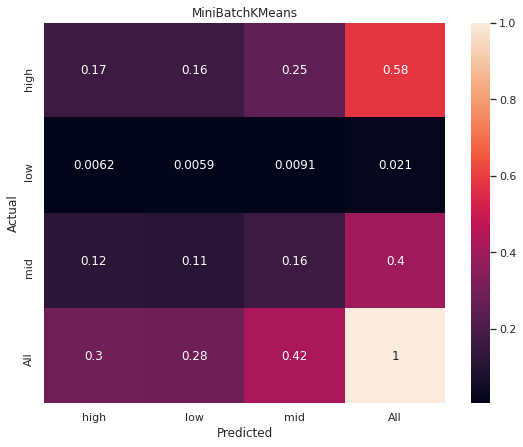


Trained MiniBatchKMeans in 217.56095910072327s


In [125]:
clf = fit_model(algorithm=mb_kmeans, data=(X_small, y_small))

In [126]:
clf

Pipeline(steps=[('mean_embeddings',
                 SpacyVectorTransformer(nlp=<spacy.lang.en.English object at 0x7ff253d3b6d8>)),
                ('reduce_dim', TruncatedSVD(n_components=50)),
                ('clusterer', MiniBatchKMeans(max_iter=1, n_clusters=3))])